## Setup

Import libraries and load data for a specific dataset.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Configure paths
dataset_name = "bellevue_116th_ne12th"  # Change to your dataset
processed_dir = Path(f"../data/processed/{dataset_name}")

# Load data
clusters = pd.read_parquet(processed_dir / "clusters.parquet")
trajs = pd.read_parquet(processed_dir / "trajectories.parquet")

# Check if outliers file exists
outliers_path = processed_dir / "outliers.parquet"
if outliers_path.exists():
    outliers = pd.read_parquet(outliers_path)
    print(f"Loaded {len(clusters)} total tracks, {len(outliers)} outliers")
else:
    outliers = None
    print(f"Loaded {len(clusters)} total tracks")

Loaded 3050 total tracks, 1649 outliers


## Cluster Overview

Get a summary of all discovered clusters.

In [2]:
# Basic cluster statistics
n_total = len(clusters)
n_outliers = (clusters['cluster'] == -1).sum()
n_clustered = n_total - n_outliers
n_clusters = clusters[clusters['cluster'] >= 0]['cluster'].nunique()

print(f"Total trajectories: {n_total}")
print(f"Clustered: {n_clustered} ({100.0*n_clustered/n_total:.1f}%)")
print(f"Outliers: {n_outliers} ({100.0*n_outliers/n_total:.1f}%)")
print(f"Number of clusters: {n_clusters}")

# Cluster size distribution
cluster_sizes = clusters[clusters['cluster'] >= 0].groupby('cluster').size().sort_values(ascending=False)
print("\nCluster size statistics:")
print(f"  Largest cluster: {cluster_sizes.max()} trajectories")
print(f"  Smallest cluster: {cluster_sizes.min()} trajectories")
print(f"  Mean cluster size: {cluster_sizes.mean():.1f}")
print(f"  Median cluster size: {cluster_sizes.median():.1f}")

# Display cluster sizes
cluster_sizes

Total trajectories: 3050
Clustered: 1401 (45.9%)
Outliers: 1649 (54.1%)
Number of clusters: 11

Cluster size statistics:
  Largest cluster: 267 trajectories
  Smallest cluster: 41 trajectories
  Mean cluster size: 127.4
  Median cluster size: 128.0


cluster
3     267
2     196
4     158
7     145
9     130
8     128
0     109
6      78
5      76
1      73
10     41
dtype: int64

## Cluster Size Distribution

Visualize how many trajectories belong to each cluster.

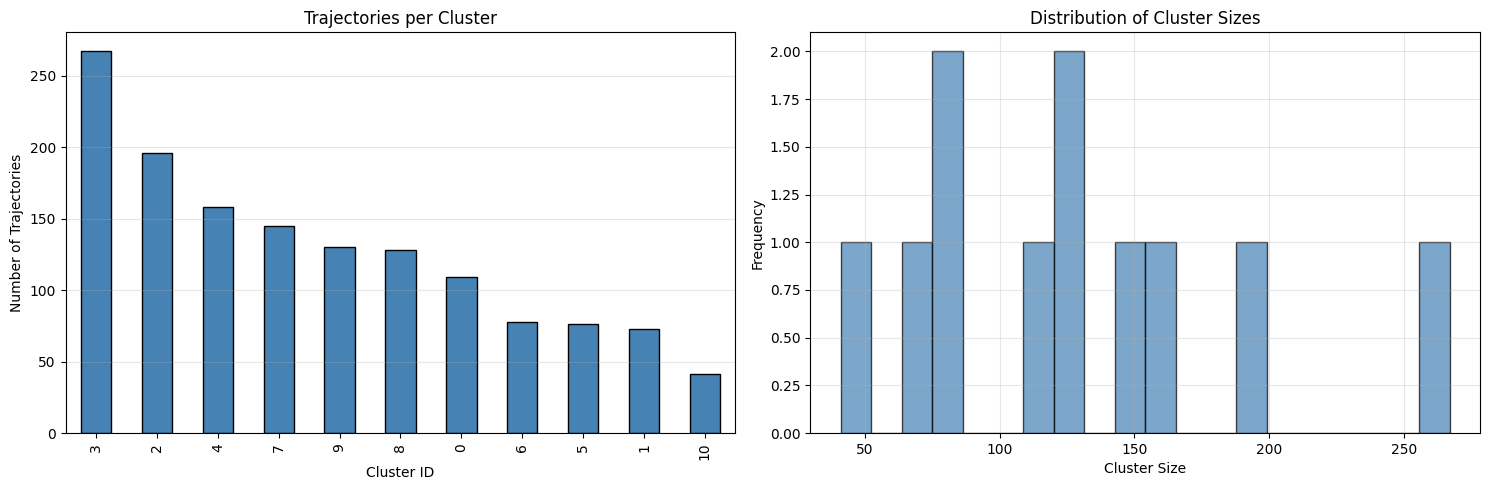

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Bar chart of cluster sizes
ax = axes[0]
cluster_sizes.plot(kind='bar', ax=ax, color='steelblue', edgecolor='black')
ax.set_xlabel('Cluster ID')
ax.set_ylabel('Number of Trajectories')
ax.set_title('Trajectories per Cluster')
ax.grid(True, alpha=0.3, axis='y')

# Histogram of cluster sizes
ax = axes[1]
ax.hist(cluster_sizes, bins=20, color='steelblue', edgecolor='black', alpha=0.7)
ax.set_xlabel('Cluster Size')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Cluster Sizes')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Spatial Distribution of Clusters

Visualize entry and exit points for all clusters.

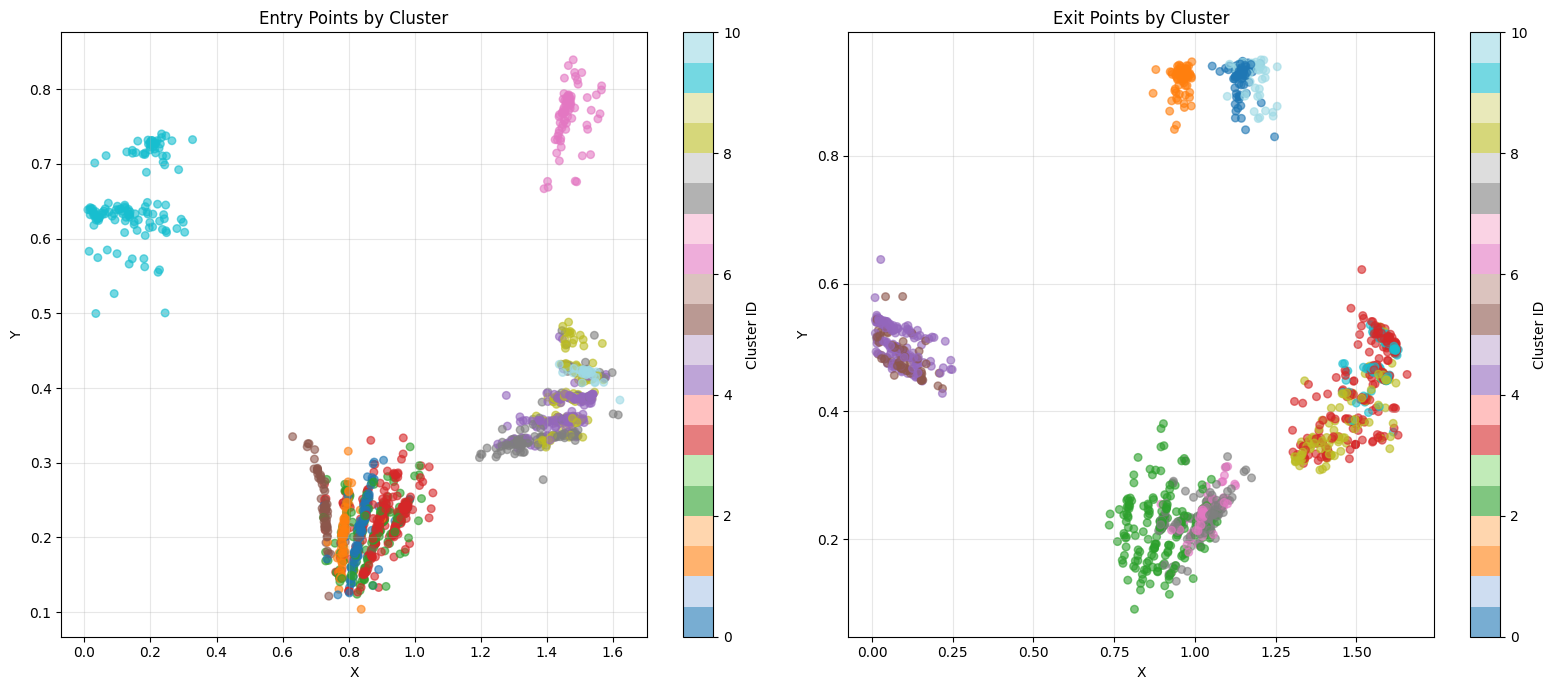

In [4]:
# Get entry/exit points for each track
clustered_data = clusters[clusters['cluster'] >= 0].copy()
track_coords = []

for _, row in clustered_data.iterrows():
    track_id = row['track_id']
    cluster_id = row['cluster']
    track_traj = trajs[trajs['track_id'] == track_id].sort_values('frame')
    
    if len(track_traj) > 0:
        track_coords.append({
            'track_id': track_id,
            'cluster': cluster_id,
            'x_entry': track_traj.iloc[0]['x'],
            'y_entry': track_traj.iloc[0]['y'],
            'x_exit': track_traj.iloc[-1]['x'],
            'y_exit': track_traj.iloc[-1]['y'],
        })

coords_df = pd.DataFrame(track_coords)

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Entry points colored by cluster
ax = axes[0]
scatter = ax.scatter(coords_df['x_entry'], coords_df['y_entry'], 
                    c=coords_df['cluster'], cmap='tab20', alpha=0.6, s=30)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Entry Points by Cluster')
plt.colorbar(scatter, ax=ax, label='Cluster ID')
ax.grid(True, alpha=0.3)

# Exit points colored by cluster
ax = axes[1]
scatter = ax.scatter(coords_df['x_exit'], coords_df['y_exit'],
                    c=coords_df['cluster'], cmap='tab20', alpha=0.6, s=30)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Exit Points by Cluster')
plt.colorbar(scatter, ax=ax, label='Cluster ID')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Visualize Individual Clusters

Plot entry-exit flow for each cluster to understand trajectory patterns.

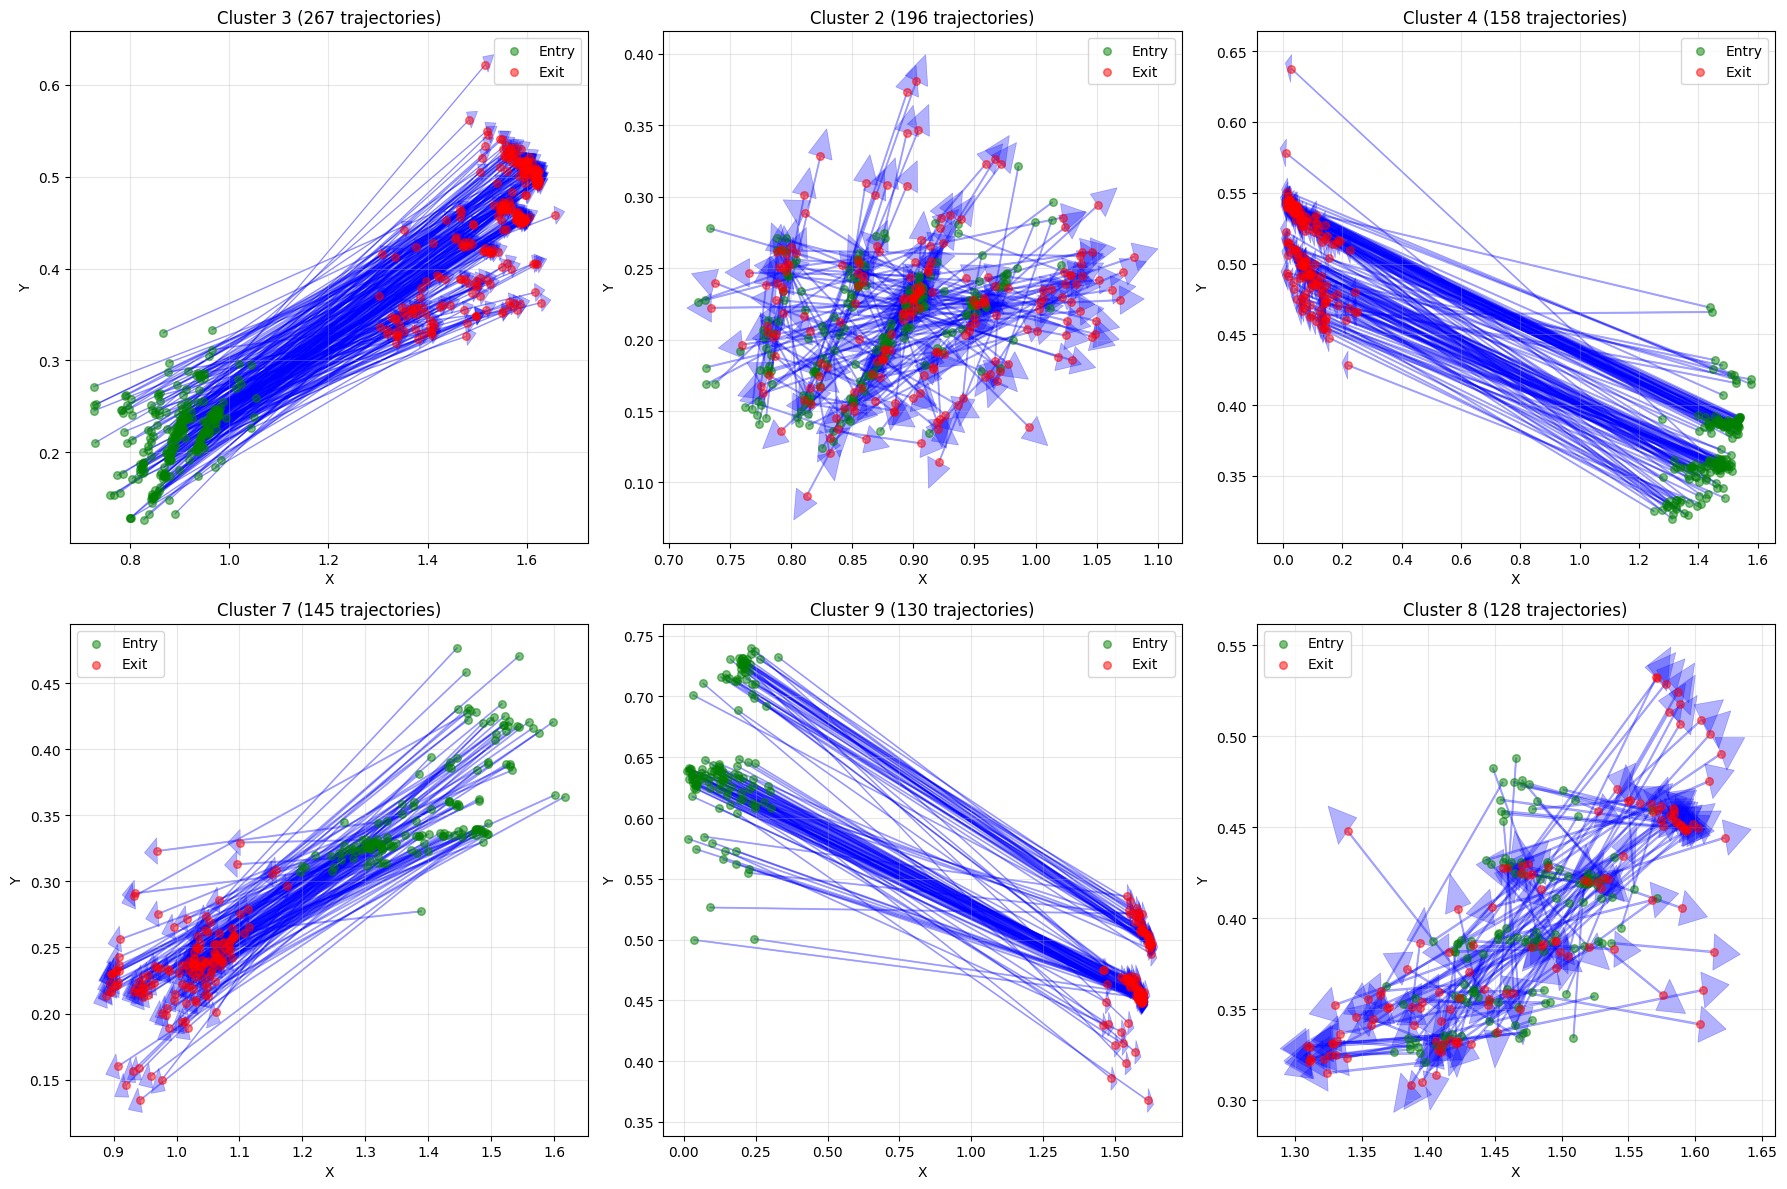

In [5]:
# Select clusters to visualize (largest ones by default)
top_n = 6
top_clusters = cluster_sizes.head(top_n).index.tolist()

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, cluster_id in enumerate(top_clusters):
    ax = axes[idx]
    
    # Get tracks in this cluster
    cluster_tracks = coords_df[coords_df['cluster'] == cluster_id]
    
    # Draw arrows from entry to exit
    for _, row in cluster_tracks.iterrows():
        ax.arrow(row['x_entry'], row['y_entry'],
                row['x_exit'] - row['x_entry'],
                row['y_exit'] - row['y_entry'],
                head_width=0.02, head_length=0.02,
                fc='blue', ec='blue', alpha=0.3, linewidth=0.5)
    
    # Mark entry and exit regions
    ax.scatter(cluster_tracks['x_entry'], cluster_tracks['y_entry'],
              c='green', s=30, alpha=0.5, label='Entry', zorder=5)
    ax.scatter(cluster_tracks['x_exit'], cluster_tracks['y_exit'],
              c='red', s=30, alpha=0.5, label='Exit', zorder=5)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(f'Cluster {cluster_id} ({len(cluster_tracks)} trajectories)')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Sample Trajectories per Cluster

Show actual trajectory paths for sample tracks from each cluster.

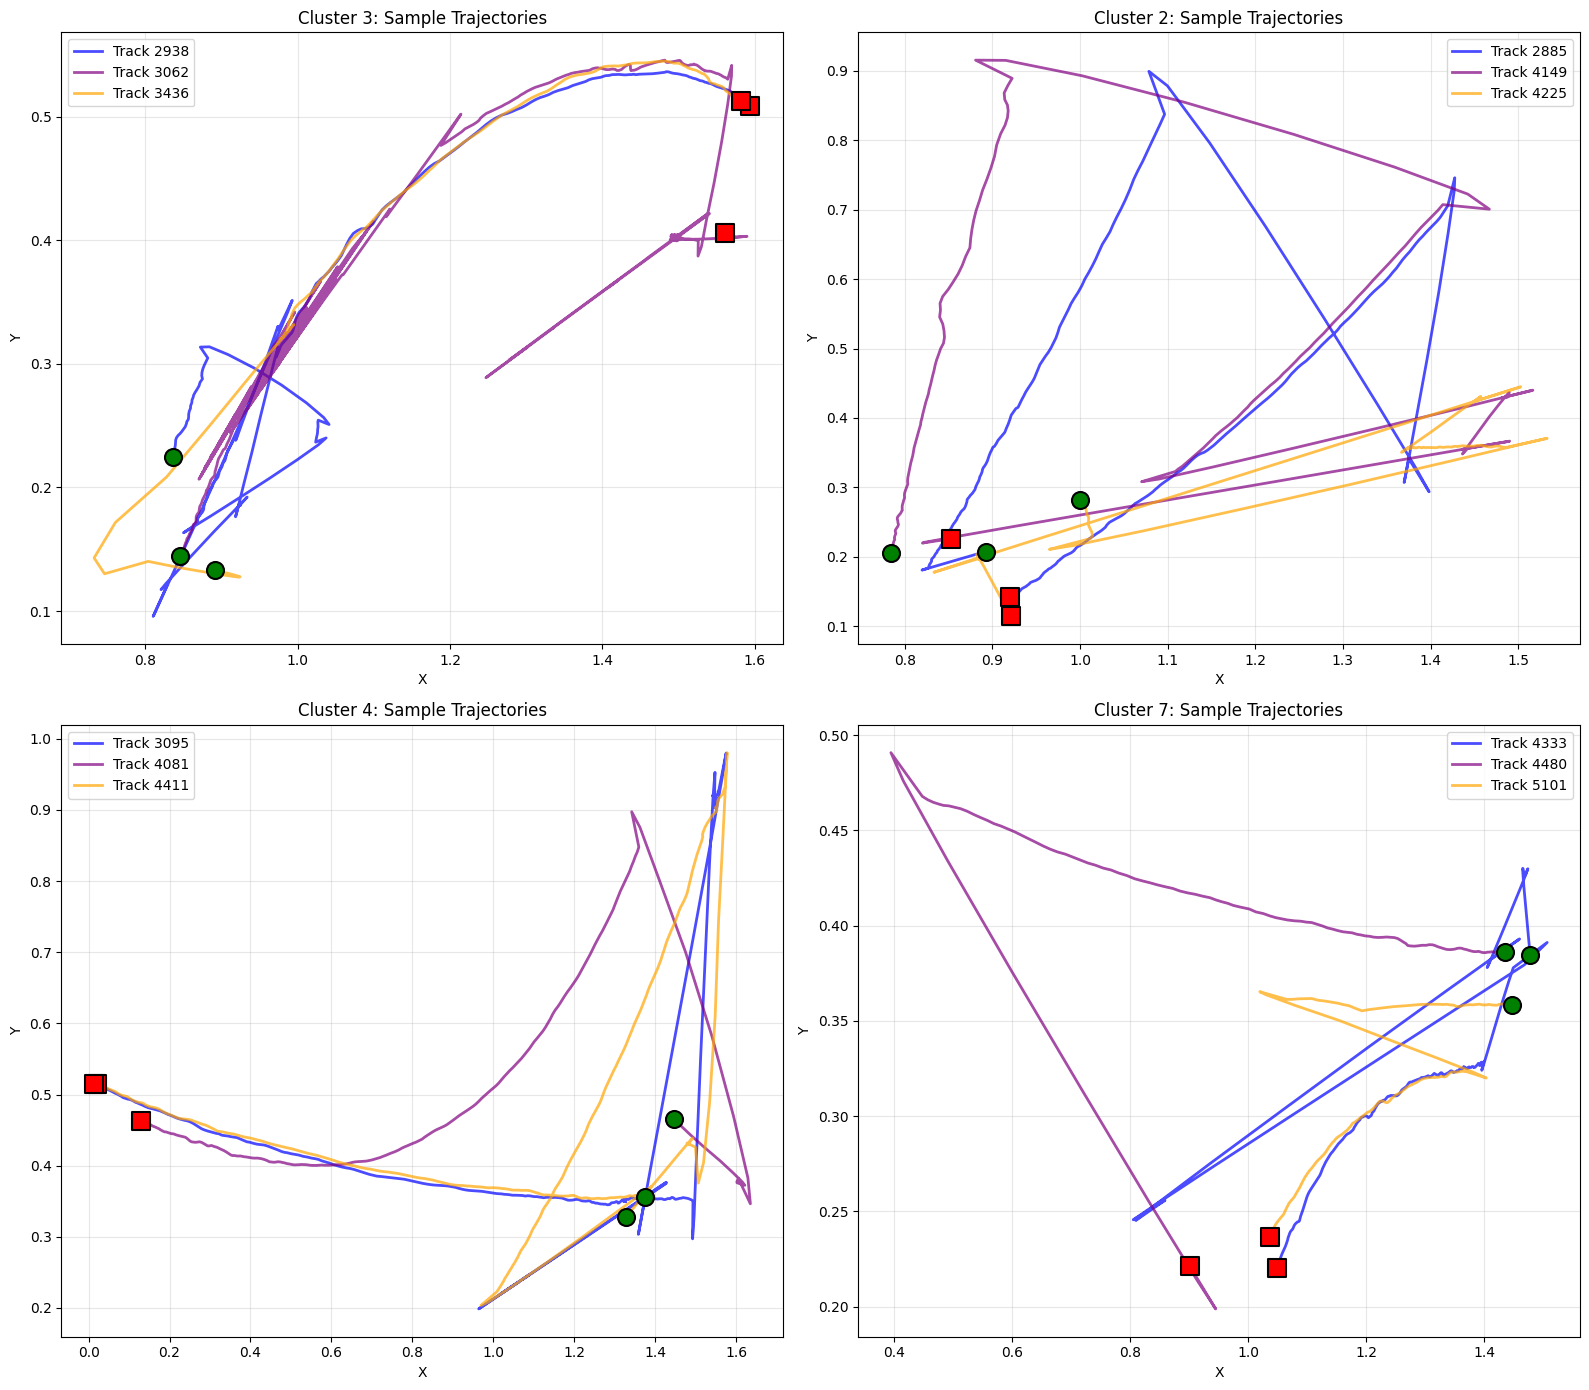

In [6]:
def plot_cluster_samples(cluster_id, n_samples=3, ax=None):
    """Plot sample trajectories from a cluster."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
    
    # Get sample tracks from this cluster
    cluster_track_ids = clustered_data[clustered_data['cluster'] == cluster_id]['track_id'].head(n_samples)
    
    colors = ['blue', 'purple', 'orange', 'cyan', 'magenta']
    
    for idx, track_id in enumerate(cluster_track_ids):
        track_traj = trajs[trajs['track_id'] == track_id].sort_values('frame')
        color = colors[idx % len(colors)]
        
        # Plot trajectory path
        ax.plot(track_traj['x'], track_traj['y'], 
               color=color, alpha=0.7, linewidth=2, label=f'Track {int(track_id)}')
        
        # Mark entry/exit
        ax.scatter(track_traj.iloc[0]['x'], track_traj.iloc[0]['y'],
                  c='green', s=150, marker='o', edgecolor='black', linewidth=1.5, zorder=10)
        ax.scatter(track_traj.iloc[-1]['x'], track_traj.iloc[-1]['y'],
                  c='red', s=150, marker='s', edgecolor='black', linewidth=1.5, zorder=10)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(f'Cluster {cluster_id}: Sample Trajectories')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    return ax

# Plot samples from top 4 clusters
top_4 = cluster_sizes.head(4).index.tolist()
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

for idx, cluster_id in enumerate(top_4):
    plot_cluster_samples(cluster_id, n_samples=3, ax=axes[idx])

plt.tight_layout()
plt.show()

## Cluster Centroids

Compute and visualize cluster centroids (average entry/exit points).

Cluster centroids:


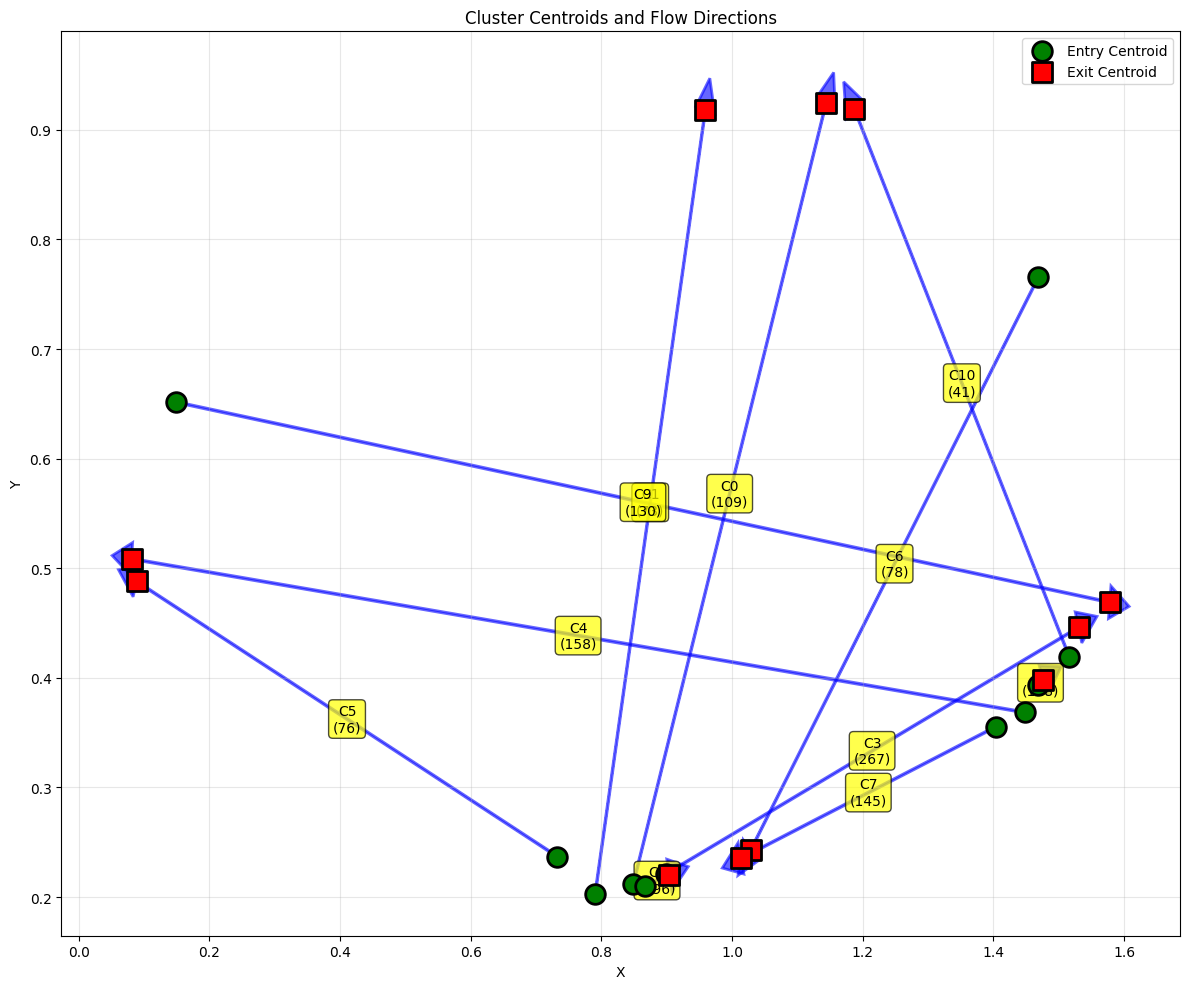

In [7]:
# Calculate cluster centroids
centroids = coords_df.groupby('cluster').agg({
    'x_entry': 'mean',
    'y_entry': 'mean',
    'x_exit': 'mean',
    'y_exit': 'mean',
    'track_id': 'count'
}).rename(columns={'track_id': 'size'})

print("Cluster centroids:")
centroids

# Visualize centroids with cluster sizes
fig, ax = plt.subplots(figsize=(12, 10))

# Draw arrows from entry centroid to exit centroid
for cluster_id, row in centroids.iterrows():
    ax.arrow(row['x_entry'], row['y_entry'],
            row['x_exit'] - row['x_entry'],
            row['y_exit'] - row['y_entry'],
            head_width=0.03, head_length=0.03,
            fc='blue', ec='blue', alpha=0.6, linewidth=2)
    
    # Label with cluster ID and size
    mid_x = (row['x_entry'] + row['x_exit']) / 2
    mid_y = (row['y_entry'] + row['y_exit']) / 2
    ax.text(mid_x, mid_y, f"C{cluster_id}\n({int(row['size'])})",
           fontsize=10, ha='center', va='center',
           bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

# Mark entry and exit centroids
ax.scatter(centroids['x_entry'], centroids['y_entry'],
          c='green', s=200, marker='o', edgecolor='black', linewidth=2,
          label='Entry Centroid', zorder=10)
ax.scatter(centroids['x_exit'], centroids['y_exit'],
          c='red', s=200, marker='s', edgecolor='black', linewidth=2,
          label='Exit Centroid', zorder=10)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Cluster Centroids and Flow Directions')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Interactive Cluster Explorer

Select any cluster ID to visualize all its trajectories.

Exploring Cluster 0
Number of trajectories: 109


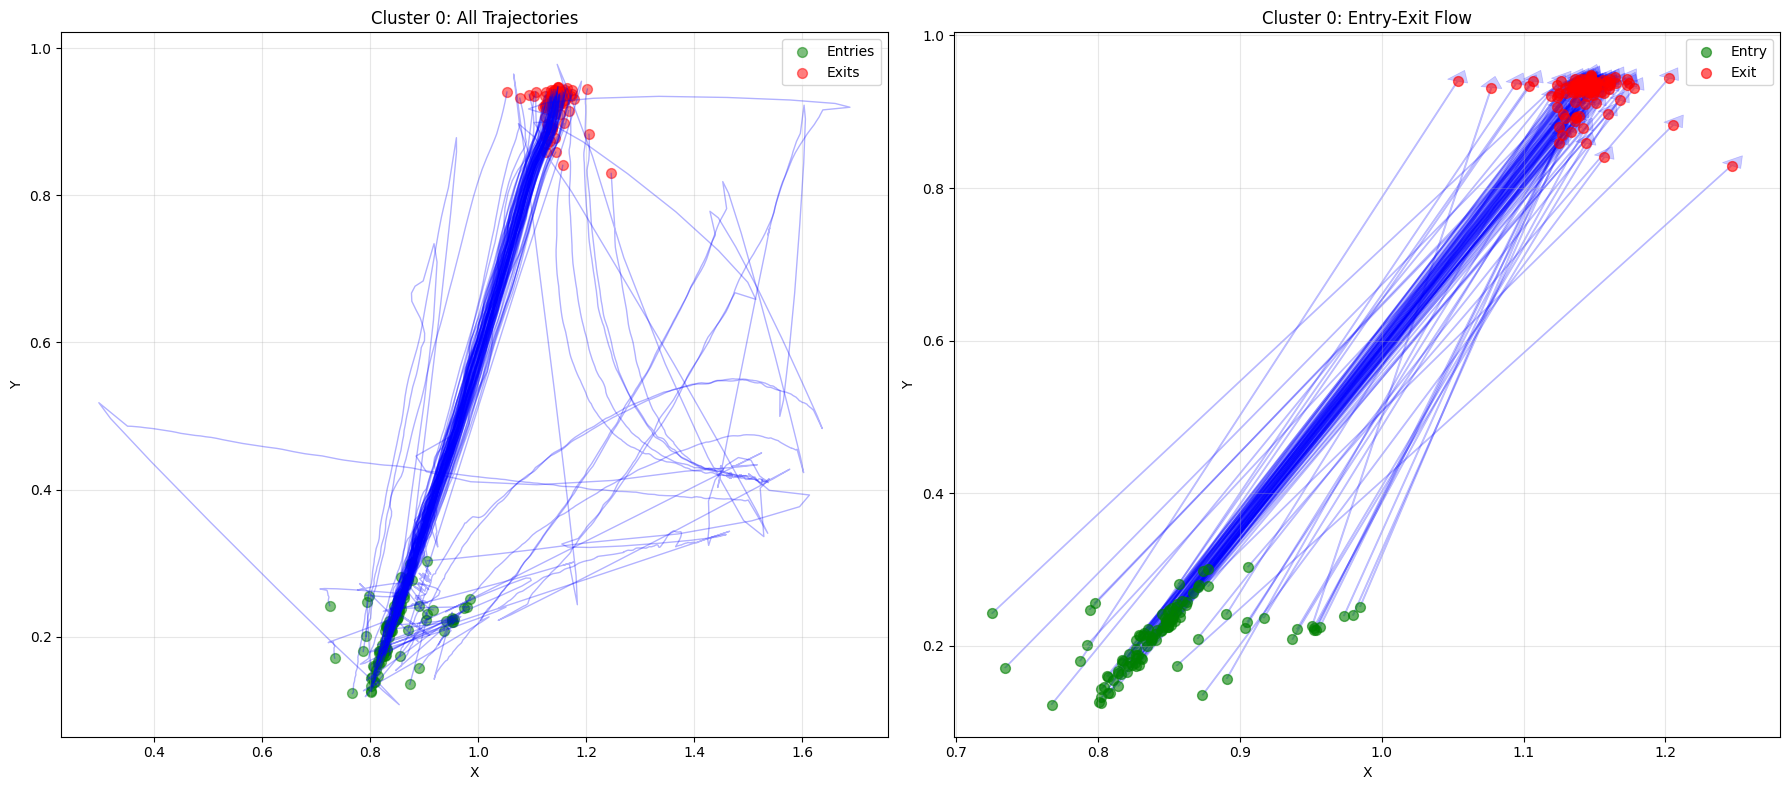

In [8]:
# Choose a cluster to explore in detail
selected_cluster = 0  # Change this to explore different clusters

print(f"Exploring Cluster {selected_cluster}")
cluster_track_ids = clustered_data[clustered_data['cluster'] == selected_cluster]['track_id']
print(f"Number of trajectories: {len(cluster_track_ids)}")

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Left: All trajectories in cluster
ax = axes[0]
for track_id in cluster_track_ids:
    track_traj = trajs[trajs['track_id'] == track_id].sort_values('frame')
    ax.plot(track_traj['x'], track_traj['y'], 'b-', alpha=0.3, linewidth=1)

# Mark average entry/exit
cluster_coords = coords_df[coords_df['cluster'] == selected_cluster]
ax.scatter(cluster_coords['x_entry'], cluster_coords['y_entry'],
          c='green', s=50, alpha=0.5, label='Entries')
ax.scatter(cluster_coords['x_exit'], cluster_coords['y_exit'],
          c='red', s=50, alpha=0.5, label='Exits')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title(f'Cluster {selected_cluster}: All Trajectories')
ax.legend()
ax.grid(True, alpha=0.3)

# Right: Entry-exit flow diagram
ax = axes[1]
for _, row in cluster_coords.iterrows():
    ax.arrow(row['x_entry'], row['y_entry'],
            row['x_exit'] - row['x_entry'],
            row['y_exit'] - row['y_entry'],
            head_width=0.015, head_length=0.015,
            fc='blue', ec='blue', alpha=0.2, linewidth=0.5)

ax.scatter(cluster_coords['x_entry'], cluster_coords['y_entry'],
          c='green', s=50, alpha=0.6, label='Entry')
ax.scatter(cluster_coords['x_exit'], cluster_coords['y_exit'],
          c='red', s=50, alpha=0.6, label='Exit')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title(f'Cluster {selected_cluster}: Entry-Exit Flow')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Export Cluster Information

Save cluster analysis results for further use.

In [9]:
# Export cluster summary
cluster_summary = coords_df.groupby('cluster').agg({
    'track_id': 'count',
    'x_entry': ['mean', 'std'],
    'y_entry': ['mean', 'std'],
    'x_exit': ['mean', 'std'],
    'y_exit': ['mean', 'std']
})

cluster_summary.columns = ['_'.join(col).strip() for col in cluster_summary.columns.values]
cluster_summary.rename(columns={'track_id_count': 'size'}, inplace=True)

# Save to CSV
output_path = processed_dir / "cluster_summary.csv"
cluster_summary.to_csv(output_path)
print(f"Saved cluster summary to {output_path}")

# Display
cluster_summary

Saved cluster summary to ../data/processed/bellevue_116th_ne12th/cluster_summary.csv


,size,x_entry_mean,x_entry_std,y_entry_mean,y_entry_std,x_exit_mean,x_exit_std,y_exit_mean,y_exit_std
cluster,,,,,,,,,
0,109,0.848525,0.046132,0.211492,0.040570,1.143907,0.021644,0.924646,0.022691
1,73,0.790263,0.024179,0.202338,0.038449,0.958941,0.022148,0.917872,0.021447
2,196,0.866171,0.066254,0.210063,0.038946,0.903828,0.081269,0.220051,0.049590
3,267,0.898326,0.063438,0.220880,0.037371,1.530130,0.087319,0.445971,0.064761
4,158,1.447599,0.072032,0.368534,0.027180,0.080888,0.056749,0.508512,0.031308
5,76,0.732538,0.035542,0.236918,0.043693,0.088596,0.050010,0.487905,0.030259
6,78,1.468703,0.035730,0.765588,0.036680,1.028304,0.049023,0.242686,0.027271
7,145,1.403417,0.096152,0.355300,0.040276,1.013587,0.064451,0.235309,0.031301
8,128,1.467463,0.044588,0.393425,0.043297,1.476390,0.095638,0.397594,0.059607
